In [56]:
import pandas as pd
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [11]:
# import the example sentences with embeddings
data = pd.read_csv('example_sentences_embeddings.csv')

In [12]:
# create a new coumn "id", remove the string "essay" from the column "essay_id"
data['essay_id'] = data['essay_id'].str.replace('essay', '')  

In [17]:
# create a new column "treatment", essay 1- 51 are in the treatement group
data['treatment'] = np.where(data['essay_id'].astype(int) < 52, 1, 0)

In [52]:
# compute pairwise distance for each treatment group, use cosine distance
treatment_group = data[data['treatment'] == 1]
treatment_group = treatment_group.drop(columns=['essay_id', 'treatment', 'example sentences'])
# Convert each row to a numpy array
treatment_group ['embedding'] = treatment_group ['embedding'].apply(lambda x: np.array(eval(x)))
# calculate the pairwise distance using cosinse distance
treatment_group_similarity = cosine_similarity(treatment_group['embedding'].tolist(), treatment_group['embedding'].tolist())

# repeat the above steps for the control group
control_group = data[data['treatment'] == 0]
control_group = control_group.drop(columns=['essay_id', 'treatment', 'example sentences'])
control_group ['embedding'] = control_group ['embedding'].apply(lambda x: np.array(eval(x)))
control_group_similarity = cosine_similarity(control_group['embedding'].tolist(), control_group['embedding'].tolist())



In [54]:
# calculate average pairwise distance for each group
treatment_group_avg = np.mean(treatment_group_similarity)
control_group_avg = np.mean(control_group_similarity)
print(treatment_group_avg, control_group_avg)

0.3911316476976102 0.38022417226712


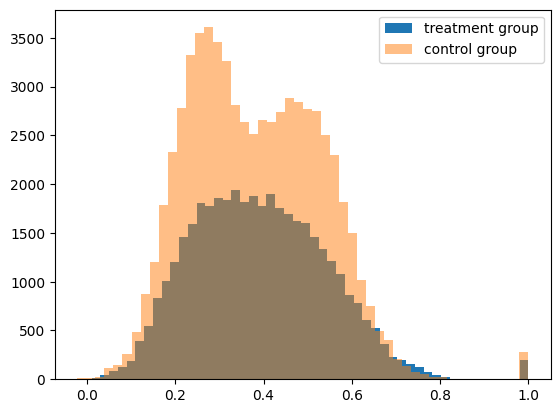

In [61]:
# plot histogram of pairwise distance for each group
plt.hist(treatment_group_similarity.flatten(), bins=50, alpha=1, label='treatment group')
plt.hist(control_group_similarity.flatten(), bins=50, alpha=0.5, label='control group')
plt.legend(loc='upper right')
plt.show()


In [62]:
# calculate the standard deviation of the pairwise distance for each group
treatment_group_std = np.std(treatment_group_similarity)
control_group_std = np.std(control_group_similarity)
print(treatment_group_std, control_group_std)



0.15169882953307542 0.14828270688470202
